In [1]:
# Cargando las librerias necesarias para el proyecto
import numpy as np
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
%matplotlib inline
import os
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

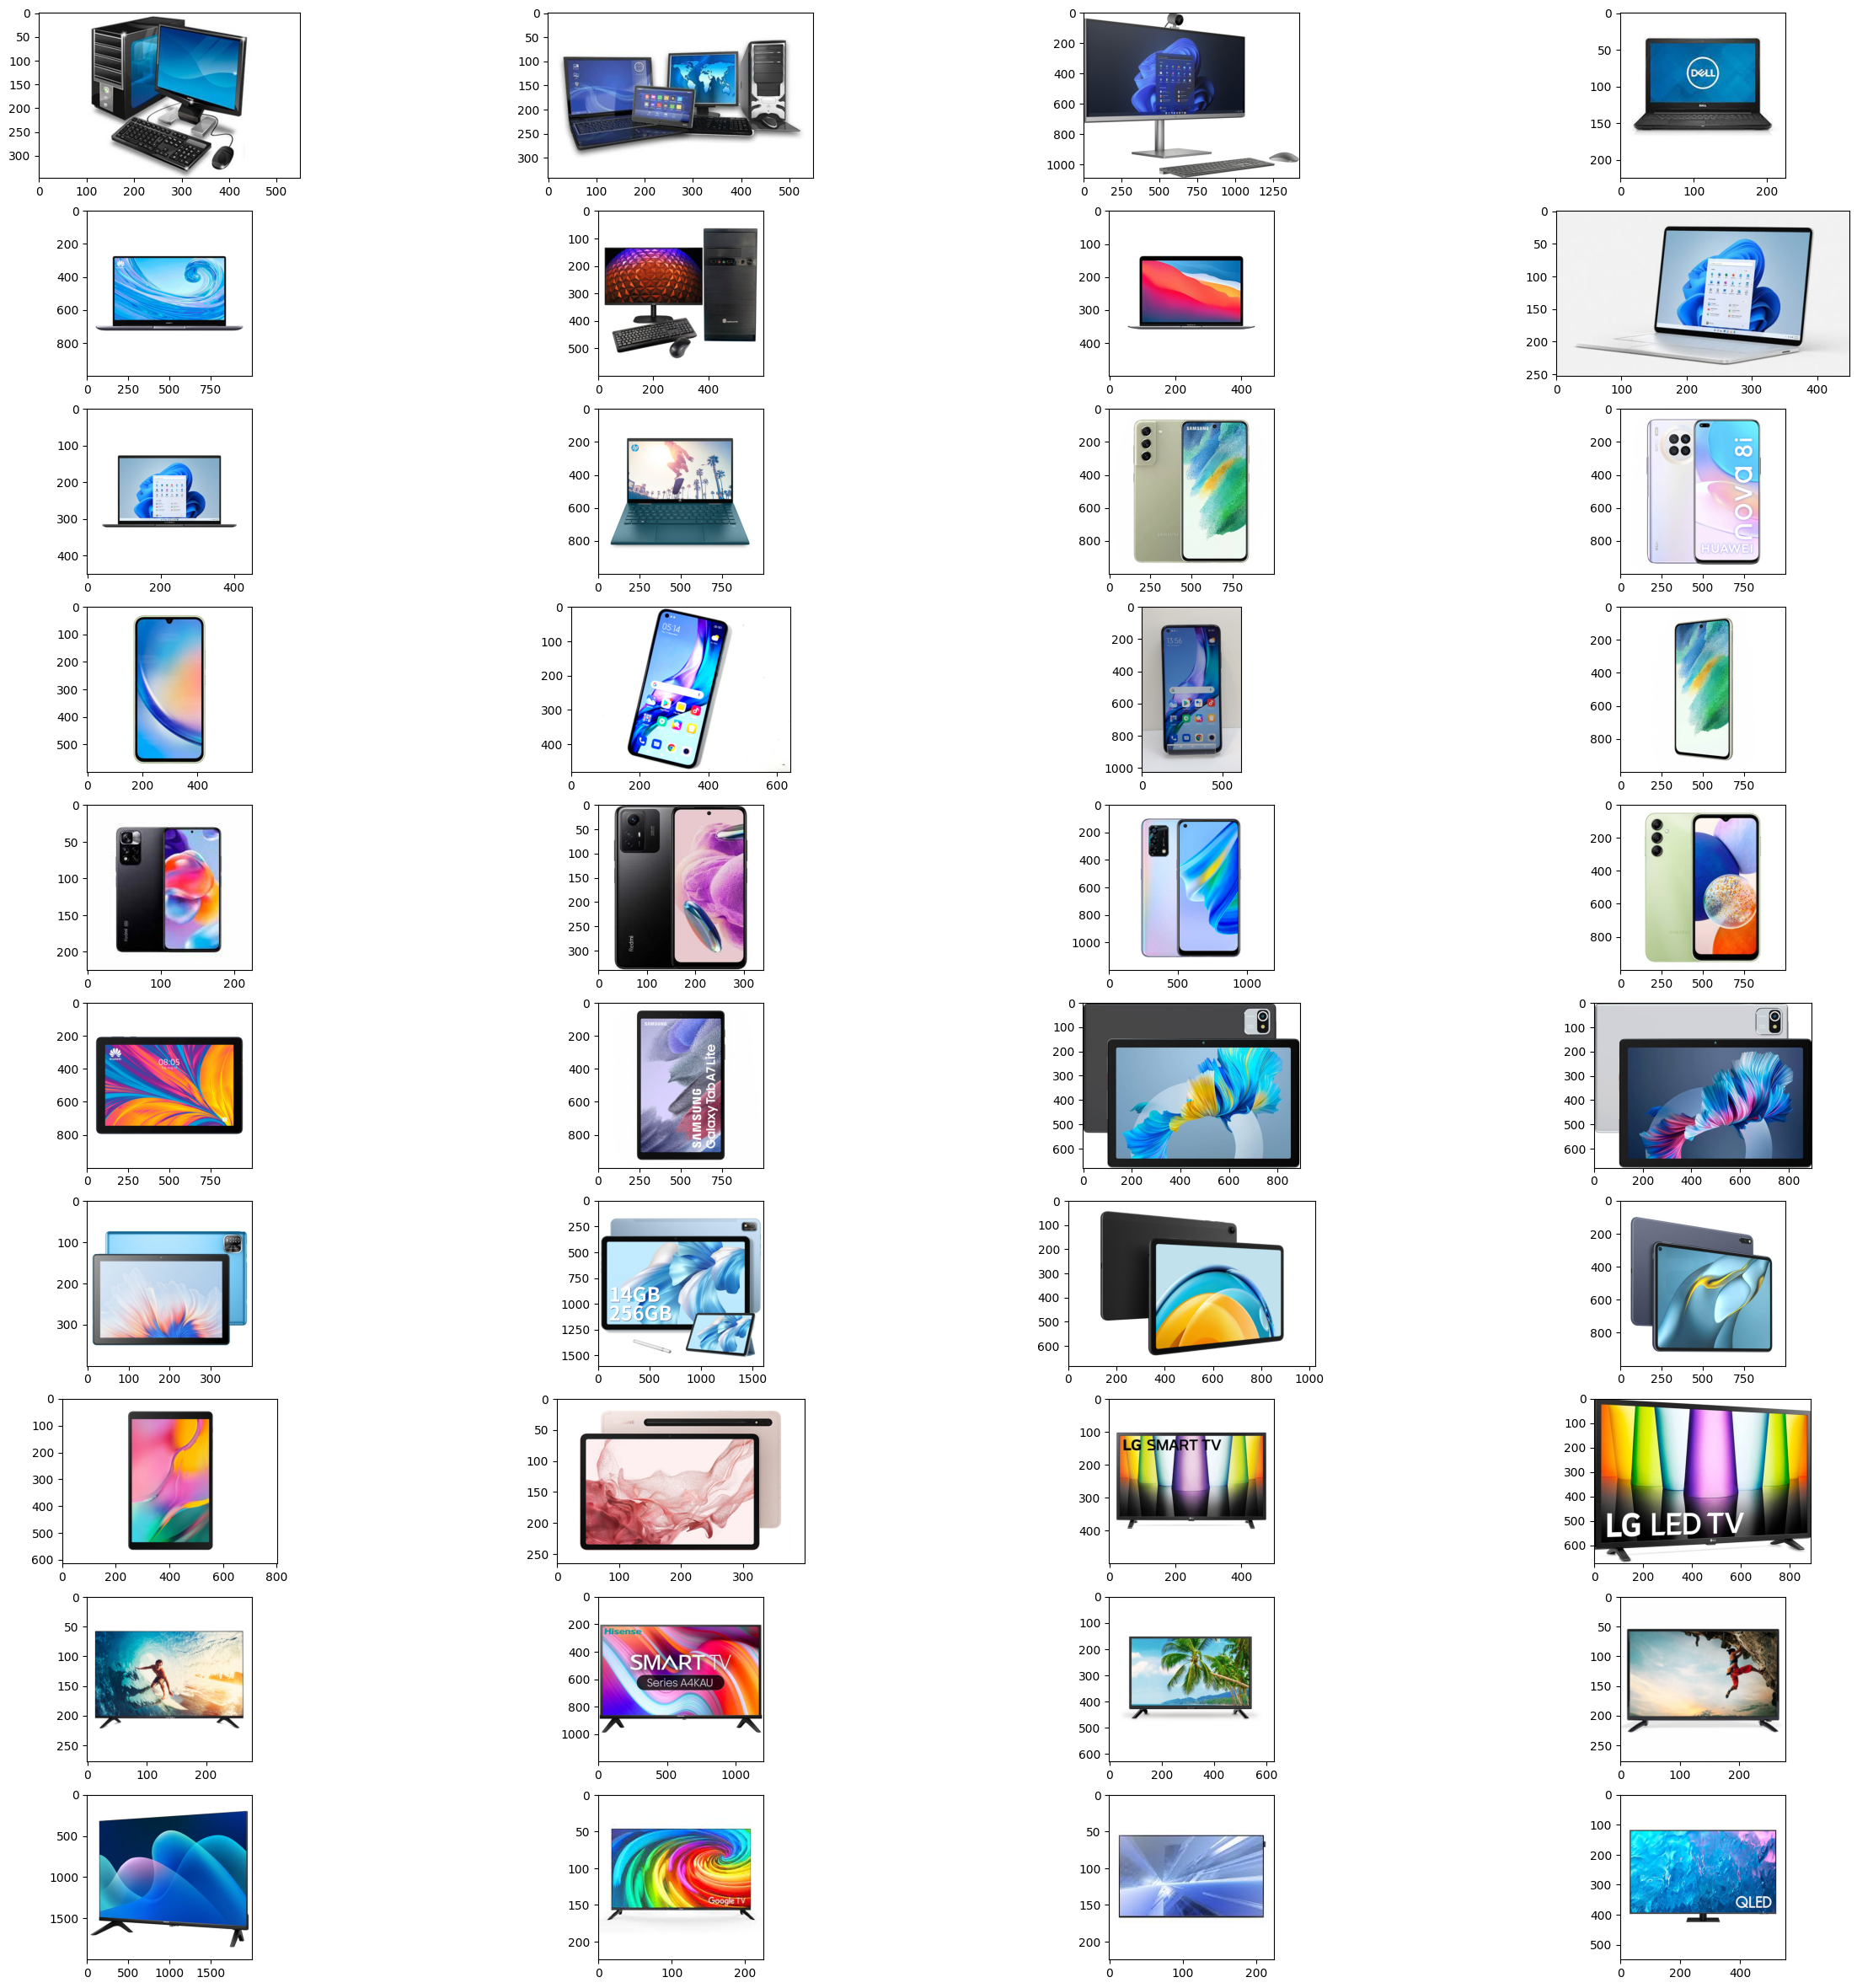

In [2]:


# Cargando los datos
modelpath = "./models/"
dataset = "./dataset/images/"
train_path = dataset + "train/"
test_path = dataset + "test/"

# Cambiar segun cantidad de datos
train_length = 640
# train_length = train_length + 1
test_length = 120
# test_length = test_length + 1

# Visualizando las imagenes de entrenaiento
plt.figure(figsize=(30, 30))
for i in range(1, 41):
    plt.subplot(10, 4, i)
    plt.imshow(imread(train_path+"image"+str(i) + ".jpeg"))

plt.show()

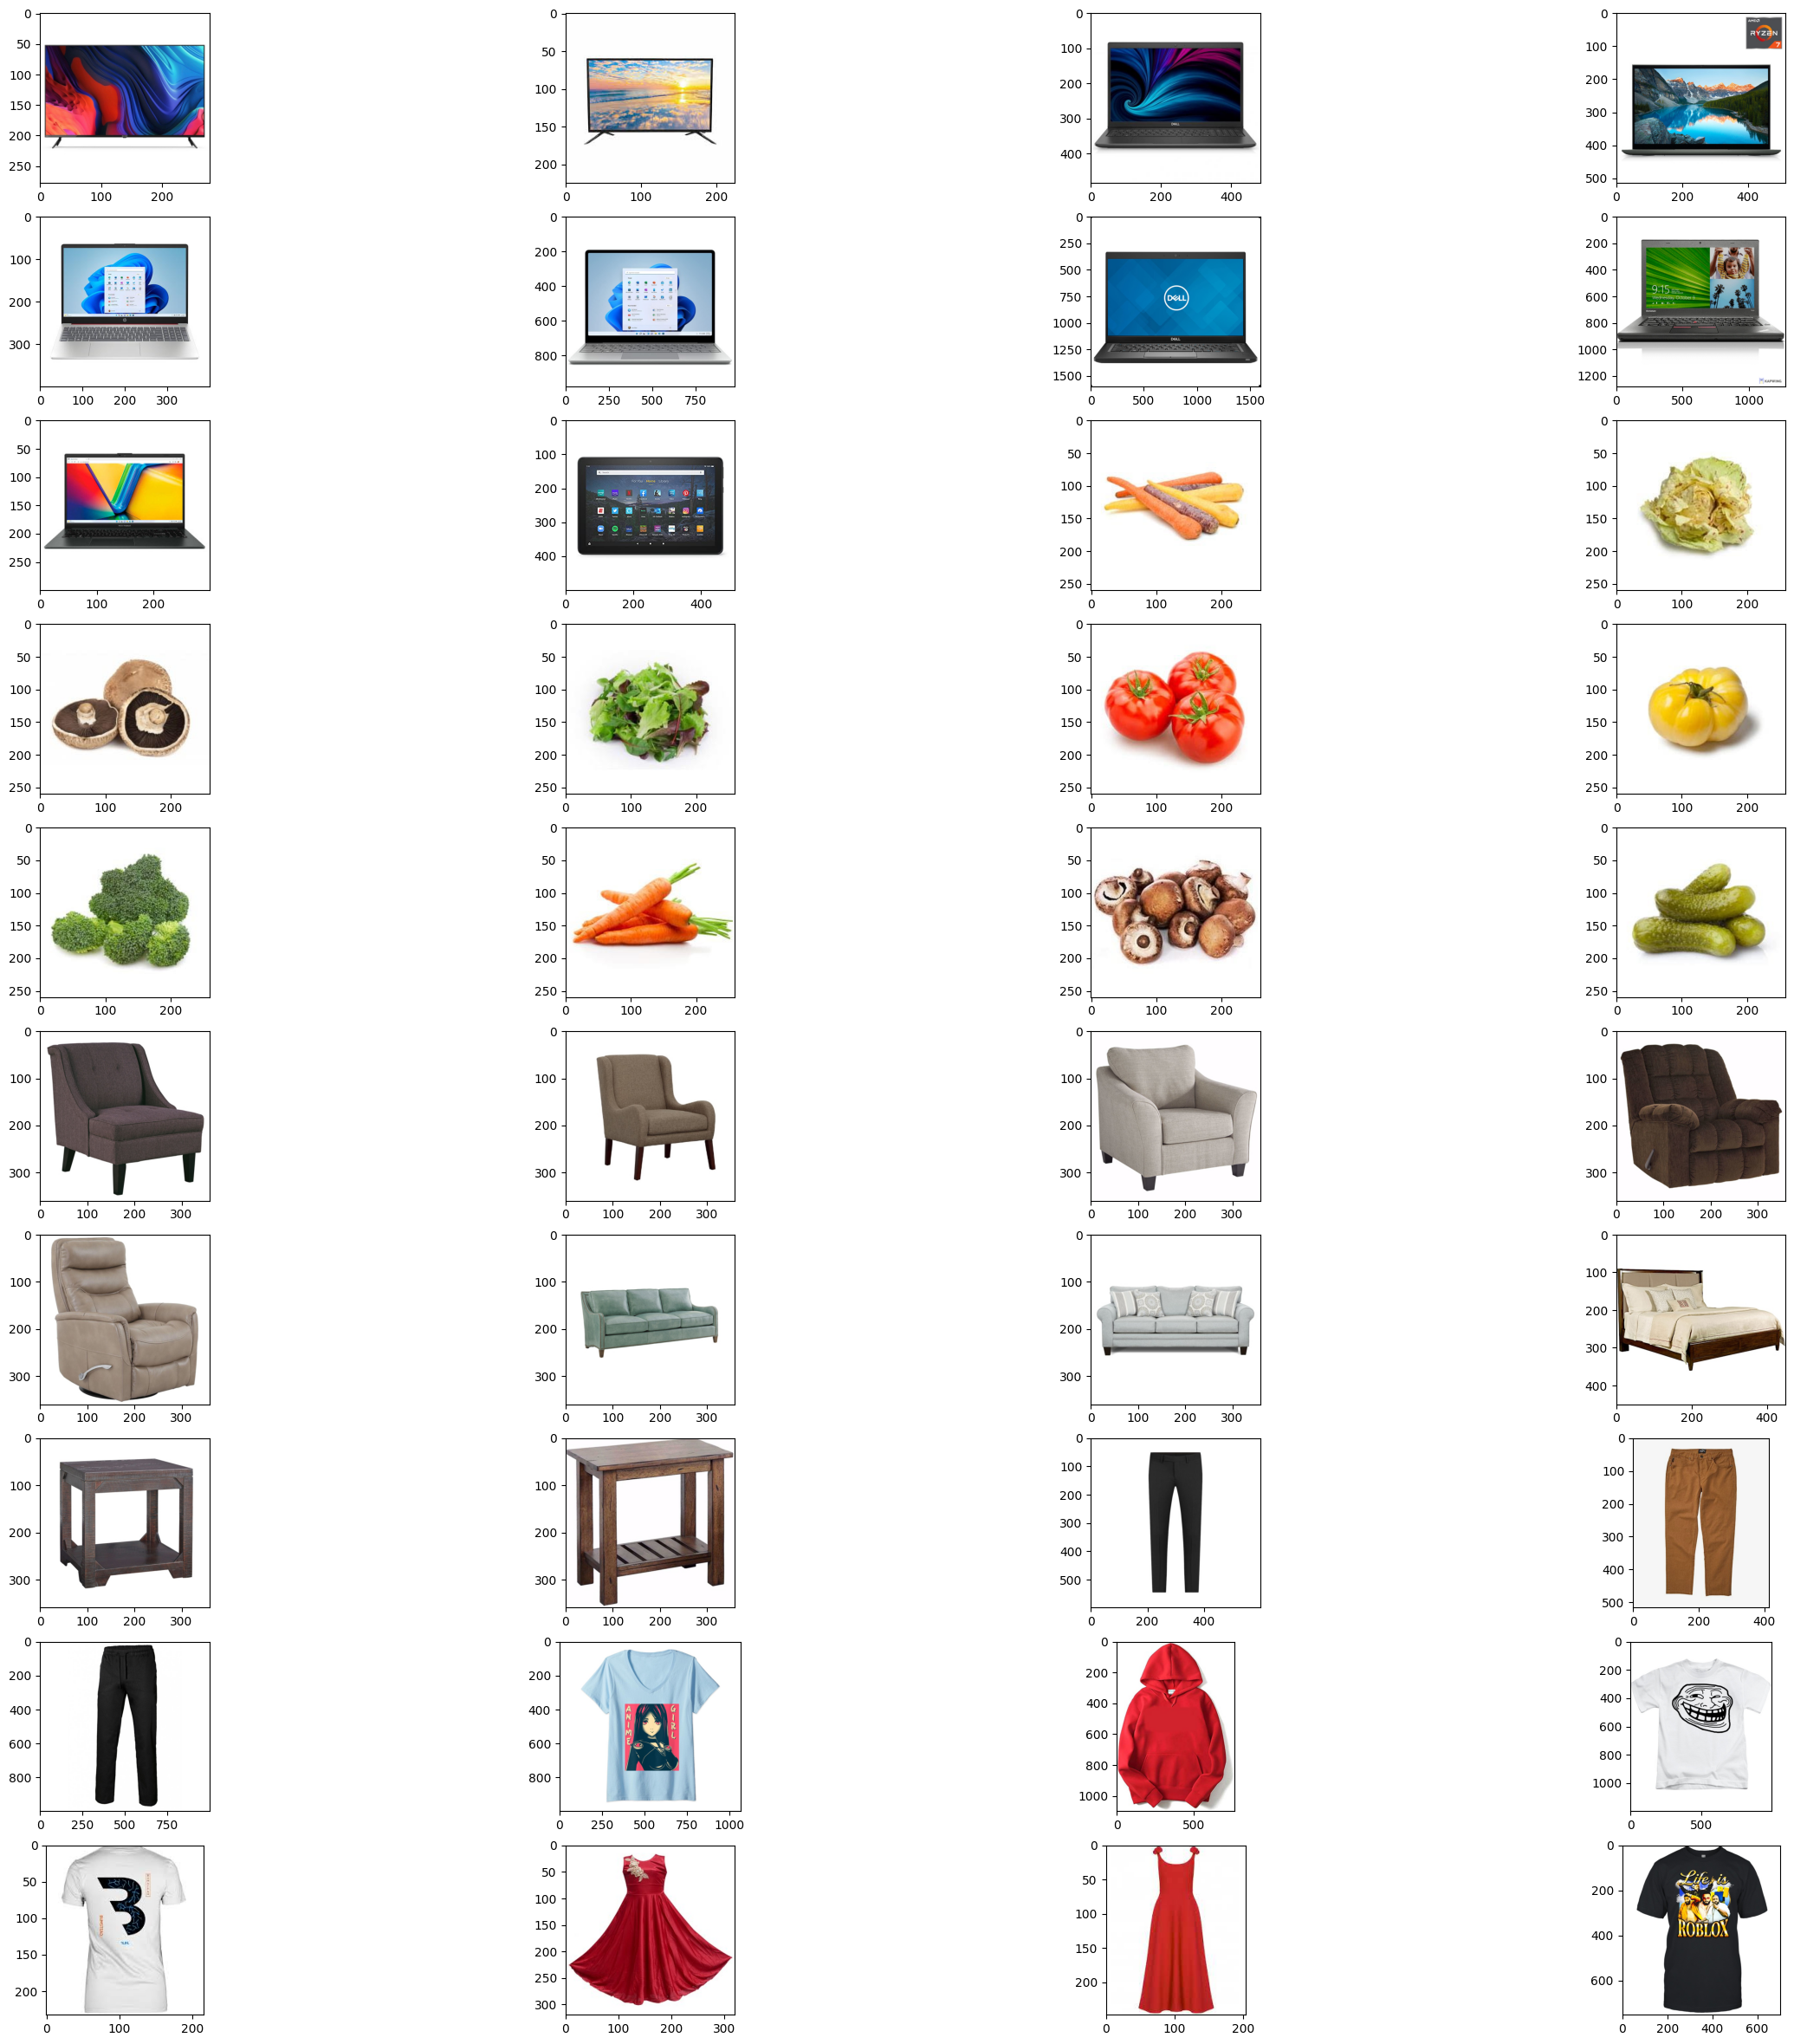

In [3]:
# Visualizando las imagenes de prueba
plt.figure(figsize=(30, 30))
for i in range(1, 41):
    plt.subplot(10, 4, i)
    plt.imshow(imread(test_path+"test_image"+str(i) + ".jpeg"))

plt.show()

In [4]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

In [5]:
labels=[0,1,2,3]
for i in range(len(labels)):
    label = str(i)
    try:
        os.mkdir(train_path + label)
        os.mkdir(test_path + label)
    except OSError:
        pass

In [6]:
# Copiando las imagenes a sus respectivas carpetas
def image_copy(df, path):
    for i in tqdm(range(len(df["name"]))):
        img = df["name"].iloc[i]
        if(df["category"].iloc[i]==0):
            shutil.copy(path+img+".jpeg",path+"0")
        elif(df["category"].iloc[i]==1):
            shutil.copy(path+img+".jpeg",path+"1")
        elif(df["category"].iloc[i]==2):
            shutil.copy(path+img+".jpeg",path+"2")
        elif(df["category"].iloc[i]==3):
            shutil.copy(path+img+".jpeg",path+"3")
    
    print("\nCopiado de imagenes completado para la carpeta: ", path)

image_copy(df_train, train_path)
image_copy(df_test, test_path)

  8%|▊         | 49/640 [00:00<00:01, 449.57it/s]

100%|██████████| 640/640 [00:01<00:00, 367.82it/s]



Copiado de imagenes completado para la carpeta:  ./dataset/images/train/


100%|██████████| 120/120 [00:00<00:00, 710.06it/s]


Copiado de imagenes completado para la carpeta:  ./dataset/images/test/


In [7]:
categories = {
    "0": "Tecnologia",
    "1": "Alimentos",
    "2": "Mobiliario",
    "3": "Prendas"
}

In [8]:
df_train["category"] = df_train["category"].astype(str)
df_test["category"] = df_test["category"].astype(str)

In [9]:
# Reemplazando los valores de las categorias por su nombre
df_train["category"] = df_train["category"].replace(categories)
df_test["category"] = df_test["category"].replace(categories)

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix

In [11]:
# Promedios de largo y ancho de las imagenes
width = []
height = []
for i in range(1, train_length+1):
    img = imread(train_path+"image"+str(i)+".jpeg")
    width.append(img.shape[0])
    height.append(img.shape[1])

# Calculando el promedio de largo y ancho de las imagenes
avg_width = np.mean(width)
avg_height = np.mean(height)

imgSize = (int(avg_width), int(avg_height))


test_datagen = ImageDataGenerator(rescale = 1/255)
                                                 

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=imgSize,
                                            batch_size=1,
                                            class_mode='categorical',
                                            shuffle=False)


c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Found 120 images belonging to 4 classes.


In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
labels = ["Technology", "Food", "Furniture", "Clothes"]

In [13]:
# Import GradCAM and SmoothGrad
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad



## Model1 

120/120 [==============================] - 36s 294ms/step
Accuracy: 0.8500
Misclass: 0.1500


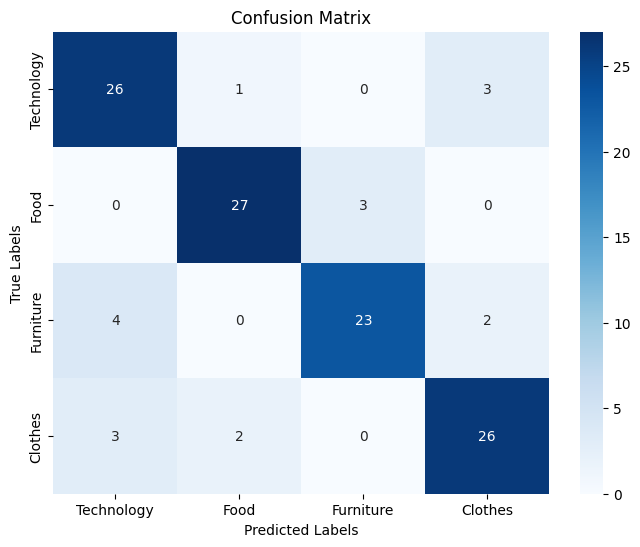

In [14]:

model1 = load_model(modelpath + 'iter_2_model1.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model1.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_1 = confusion_matrix(y_pred=predicted_classes, y_true=true_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
accuracy = np.trace(conf_matrix_1) / float(np.sum(conf_matrix_1))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

In [56]:
# Using GradCAM for model 1

img, label = test_set[10]

layer_name = "max_pooling2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')


Text(0.5, 1.0, 'GradCAM Modelo 1')

Text(0.5, 1.0, 'GradCAM Modelo 1')

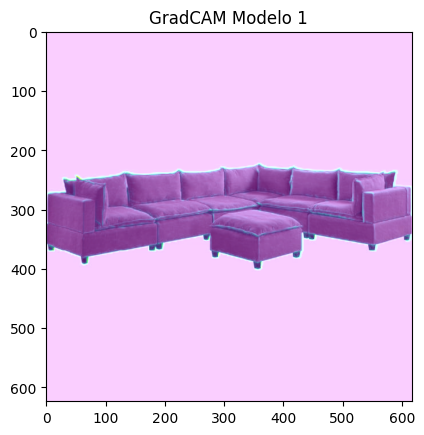

In [53]:
img, label = test_set[86]

# layer_name = "conv2d_4"
layer_name = "max_pooling2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

In [62]:
img, label = test_set[110]

layer_name = "max_pooling2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

Text(0.5, 1.0, 'GradCAM Modelo 1')

In [65]:
img, label = test_set[31]

layer_name = "max_pooling2d_4"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model1, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam, cmap="viridis")
plt.title('GradCAM Modelo 1')

Text(0.5, 1.0, 'GradCAM Modelo 1')

### Model 2


120/120 [==============================] - 16s 130ms/step
Accuracy: 0.7917
Misclass: 0.2083


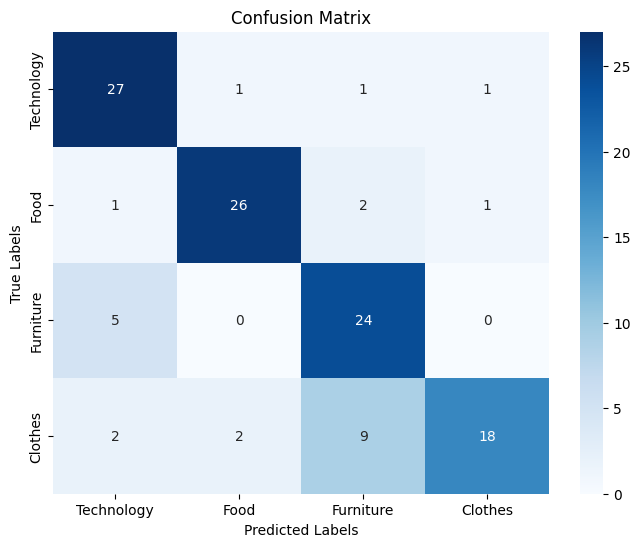

In [19]:

model2 = load_model(modelpath + 'iter_2_model2.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model2.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_2 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_2) / float(np.sum(conf_matrix_2))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 2')

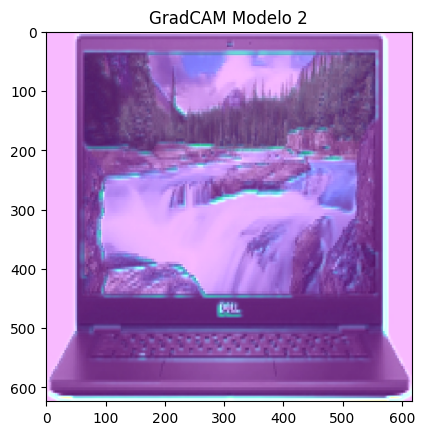

In [66]:
# Using GradCAM for model 2

img, label = test_set[10]

layer_name = "max_pooling2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

In [67]:
# Using GradCAM for model 2

img, label = test_set[86]

layer_name = "max_pooling2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

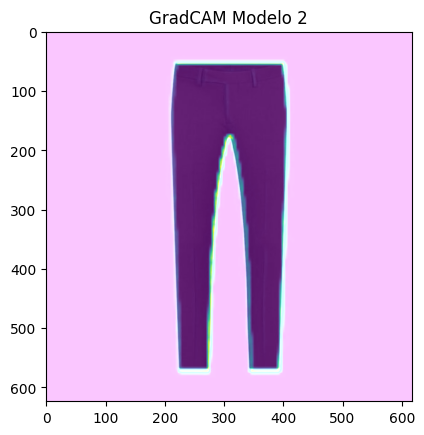

In [68]:
# Using GradCAM for model 2

img, label = test_set[110]

layer_name = "max_pooling2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

Text(0.5, 1.0, 'GradCAM Modelo 2')

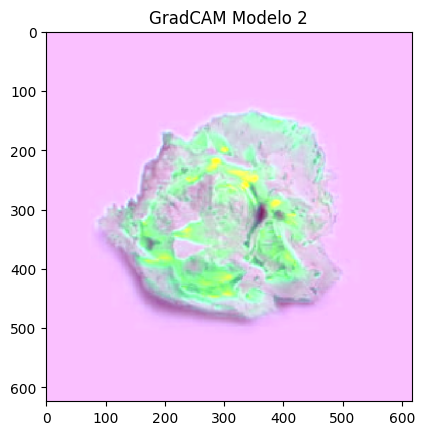

In [69]:
# Using GradCAM for model 2

img, label = test_set[31]

layer_name = "max_pooling2d_6"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model2, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 2')

## Model 3

120/120 [==============================] - 15s 124ms/step
Accuracy: 0.9000
Misclass: 0.1000


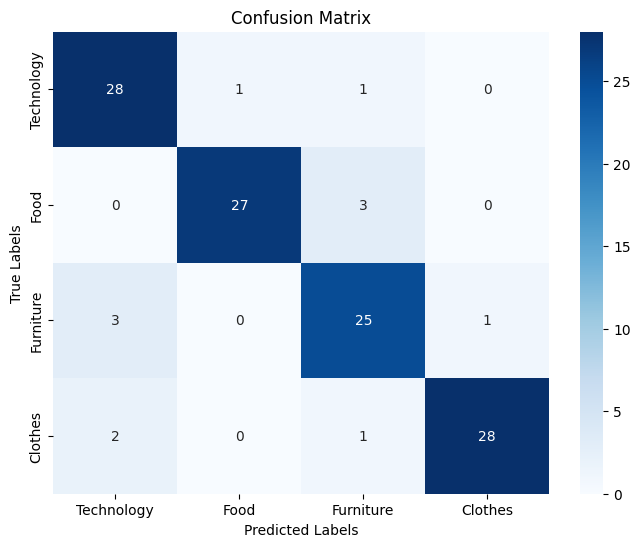

In [70]:

model3 = load_model(modelpath + 'iter_2_model3.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model3.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_3 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_3) / float(np.sum(conf_matrix_3))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 3')

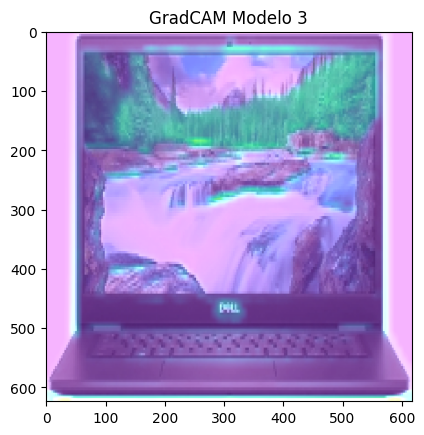

In [72]:
# Using GradCAM for model 3

img, label = test_set[10]

layer_name = "max_pooling2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

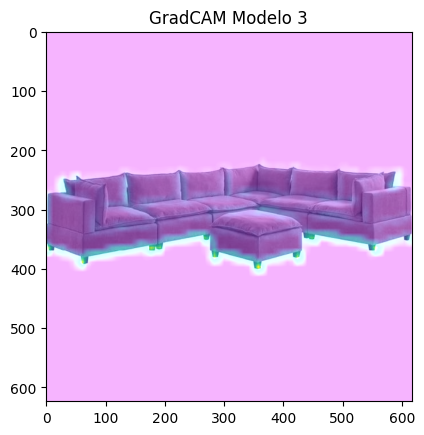

In [73]:
# Using GradCAM for model 3

img, label = test_set[86]

layer_name = "max_pooling2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

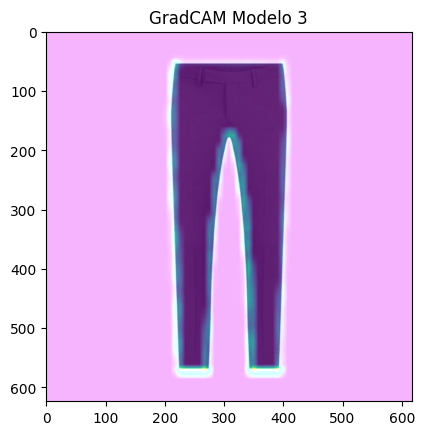

In [74]:
# Using GradCAM for model 3

img, label = test_set[110]

layer_name = "max_pooling2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

Text(0.5, 1.0, 'GradCAM Modelo 3')

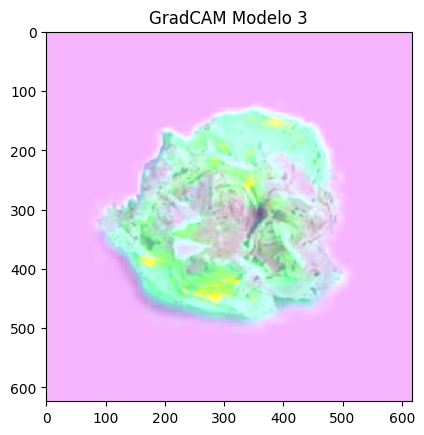

In [75]:
# Using GradCAM for model 3

img, label = test_set[31]

layer_name = "max_pooling2d_9"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model3, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 3')

## Model 4 Resnet


120/120 [==============================] - 53s 431ms/step
Accuracy: 0.7500
Misclass: 0.2500


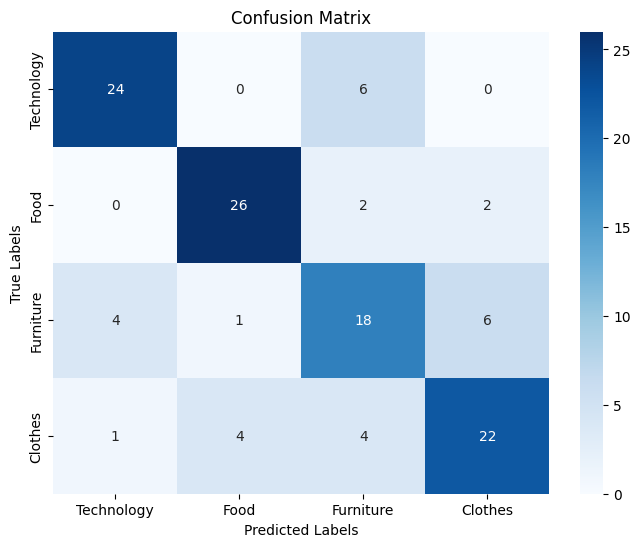

In [76]:

model4 = load_model(modelpath + 'iter_2_model4.keras')
# Assuming 'model' is your trained model and 'test_set' is your test data generator

# Calculate the number of steps per epoch for the test set
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

# Make predictions on the test set
predictions = model4.predict(test_set, steps=test_steps_per_epoch)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


true_classes = test_set.classes

# Generate confusion matrix
conf_matrix_4 = confusion_matrix(true_classes, predicted_classes)


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_4, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

accuracy = np.trace(conf_matrix_4) / float(np.sum(conf_matrix_4))
misclass = 1 - accuracy
print('Accuracy: {:.4f}'.format(accuracy))
print('Misclass: {:.4f}'.format(misclass))

# Show the plot
plt.show()

Text(0.5, 1.0, 'GradCAM Modelo 4')

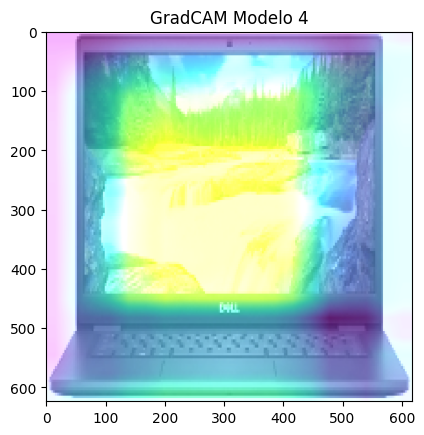

In [77]:
img, label = test_set[10]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

Text(0.5, 1.0, 'GradCAM Modelo 4')

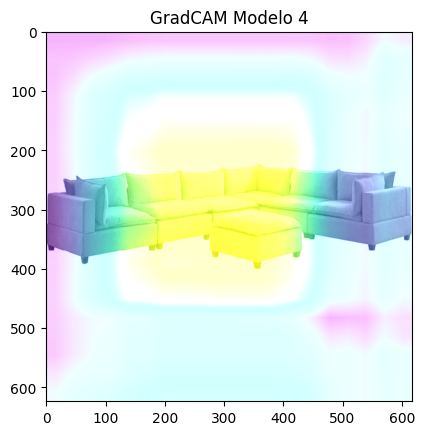

In [78]:
img, label = test_set[86]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

c:\Users\Andrès DLR\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_explain\utils\display.py:112: RuntimeWarning: invalid value encountered in divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


Text(0.5, 1.0, 'GradCAM Modelo 4')

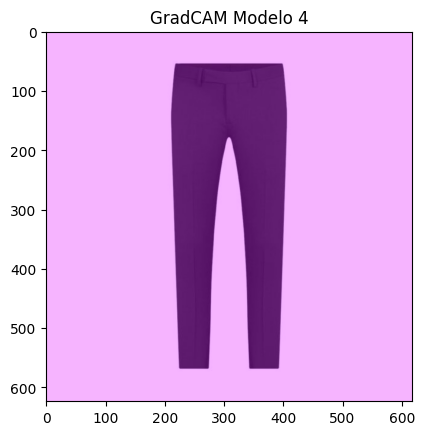

In [79]:
img, label = test_set[110]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')

Text(0.5, 1.0, 'GradCAM Modelo 4')

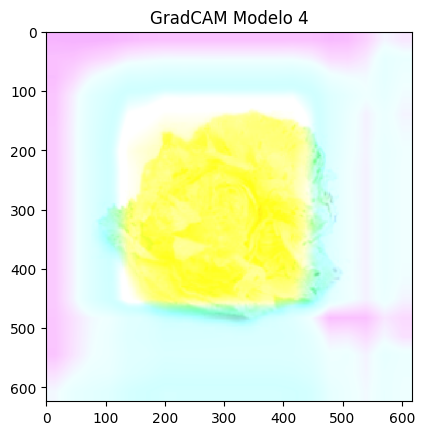

In [80]:
img, label = test_set[31]

layer_name = "conv5_block3_3_conv"

explainer = GradCAM()

grad_cam = explainer.explain((img, None), model4, class_index=0, layer_name=layer_name)

# Show results
plt.imshow(grad_cam)
plt.title('GradCAM Modelo 4')